# K-Sigma Anomaly Detection

This notebook demonstrates the K-Sigma detection algorithm for identifying radioactive sources in gamma-ray time series data.

## Algorithm Overview

The K-Sigma detector:
1. **Maintains a rolling background** (e.g., last 60 seconds)
2. **Computes statistics**: mean and standard deviation of background count rate
3. **Compares foreground** to background: metric = (foreground - mean) / std
4. **Declares alarm** if metric > k threshold (e.g., 5σ)
5. **Aggregates alarms** that are close in time (< 2 seconds apart)
6. **Records events**: start/end times, peak significance

## Dataset

Using the TopCoder Urban Data Challenge dataset (mobile NaI detector).


## Setup


In [29]:
# Imports
import sys
sys.path.insert(0, '/Users/jghawaly/CODE/gammaflow')
sys.path.insert(0, '/Users/jghawaly/CODE/urbandata-gammaflow')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# GammaFlow imports
from gammaflow import Spectrum, SpectralTimeSeries, ListMode
from gammaflow.visualization import plot_count_rate_time_series

# Detection algorithm
from src.detectors import KSigmaDetector

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✅ K-Sigma Detection - Ready!")


✅ K-Sigma Detection - Ready!


## Load Data Helper


In [30]:
def load_listmode_run(run_id, data_dir='../topcoder', dataset='training'):
    """Load a run and return ListMode object + metadata."""
    data_path = Path(data_dir)
    
    # Load listmode data
    run_file = data_path / dataset / f"{run_id}.csv"
    data = pd.read_csv(run_file, header=None, names=['time_delta_us', 'energy_keV'])
    
    # Convert to seconds
    time_deltas = data['time_delta_us'].values * 1e-6
    energies = data['energy_keV'].values
    
    # Load metadata
    answer_key_file = data_path / 'scorer' / f'answerKey_{dataset}.csv'
    answer_key = pd.read_csv(answer_key_file)
    metadata = answer_key[answer_key['RunID'] == run_id].iloc[0].to_dict()
    
    # Map SourceID to source name
    source_map = {
        0: 'Background',
        1: 'HEU',
        2: 'WGPu',
        3: 'I-131',
        4: 'Co-60',
        5: 'Tc-99m',
        6: 'Tc-99m + HEU'
    }
    metadata['SourceName'] = source_map.get(metadata['SourceID'], f"Unknown({metadata['SourceID']})")
    
    # Create ListMode
    listmode = ListMode(time_deltas, energies)
    
    return listmode, metadata

print("✅ Load function ready")


✅ Load function ready


## Load a Run with Co-60 Source


In [31]:
# Load Co-60 run (strong source)
run_id = 107313

print(f"Loading run {run_id}...")
listmode, metadata = load_listmode_run(run_id)

print(f"\nRun Metadata:")
print(f"  Source: {metadata['SourceName']}")
print(f"  Source Time: {metadata['SourceTime']:.1f} seconds")
print(f"  Speed/Offset: {metadata['Speed/Offset']:.2f}")
print(f"\n{listmode}")
print(f"  Mean rate: {listmode.mean_rate:.1f} CPS")
print(f"  Total time: {listmode.total_time:.2f} s")


Loading run 107313...

Run Metadata:
  Source: Co-60
  Source Time: 44.8 seconds
  Speed/Offset: 0.80

ListMode(n_events=60257, duration=60.81s, rate=990.9Hz)
  Mean rate: 990.9 CPS
  Total time: 60.81 s


## Convert to Time Series


In [32]:
# Convert to SpectralTimeSeries with 1-second integration
integration_time = 1.0  # seconds
stride_time = 1.0       # seconds (non-overlapping)
energy_bins = 512
energy_range = (0, 3000)  # keV

print("Converting to SpectralTimeSeries...")
time_series = SpectralTimeSeries.from_list_mode(
    listmode,
    integration_time=integration_time,
    stride_time=stride_time,
    energy_bins=energy_bins,
    energy_range=energy_range
)

print(f"\nCreated: {time_series}")
print(f"  Number of spectra: {time_series.n_spectra}")
print(f"  Time coverage: {time_series.timestamps[0]:.1f} to {time_series.timestamps[-1]:.1f} s")


Converting to SpectralTimeSeries...

Created: SpectralTimeSeries(n_spectra=61, n_bins=512, calibrated, calibration_mode=shared)
  Number of spectra: 61
  Time coverage: 0.5 to 60.5 s


## Run K-Sigma Detection


In [33]:
# Create detector
detector = KSigmaDetector(
    k_threshold=6.0,          # 5-sigma threshold
    background_window=10.0,   # 30-second background window
    foreground_window=1.0,    # 1-second foreground (matches integration time)
    aggregation_gap=2.0,      # Merge alarms < 2 seconds apart
    min_background_samples=10 # Need 10 samples before detection starts
)

print(f"Running K-Sigma Detection")
print(f"{'='*70}")
print(f"  Threshold: {detector.k_threshold} sigma")
print(f"  Background window: {detector.background_window} seconds")
print(f"  Aggregation gap: {detector.aggregation_gap} seconds")
print()

# Process time series
metrics = detector.process_time_series(time_series)

# Get summary
summary = detector.get_alarm_summary()

print(f"\n{'='*70}")
print(f"Detection Results")
print(f"{'='*70}")
print(f"Number of alarms: {summary['n_alarms']}")
print(f"Total alarm time: {summary['total_alarm_time']:.2f} seconds")
if summary['n_alarms'] > 0:
    print(f"Mean alarm duration: {summary['mean_duration']:.2f} seconds")
    print(f"Peak significance: {summary['max_peak_metric']:.2f} sigma")

if detector.alarms:
    print(f"\nAlarm Events:")
    true_source_time = metadata['SourceTime']
    for i, alarm in enumerate(detector.alarms, 1):
        print(f"  {i}. {alarm}")
        # Compare to ground truth
        if alarm.start_time <= true_source_time <= alarm.end_time:
            print(f"      ✅ Captured true source (t={true_source_time:.1f}s)")
        else:
            time_diff = min(abs(alarm.start_time - true_source_time),
                          abs(alarm.end_time - true_source_time))
            print(f"      ⚠️  Offset from true source: {time_diff:.1f}s")


Running K-Sigma Detection
  Threshold: 6.0 sigma
  Background window: 10.0 seconds
  Aggregation gap: 2.0 seconds


Detection Results
Number of alarms: 1
Total alarm time: 1.00 seconds
Mean alarm duration: 1.00 seconds
Peak significance: 7.05 sigma

Alarm Events:
  1. AlarmEvent(start=45.50s, end=46.50s, peak=7.05σ at 45.50s, duration=1.00s)
      ⚠️  Offset from true source: 0.7s


## Visualize Results


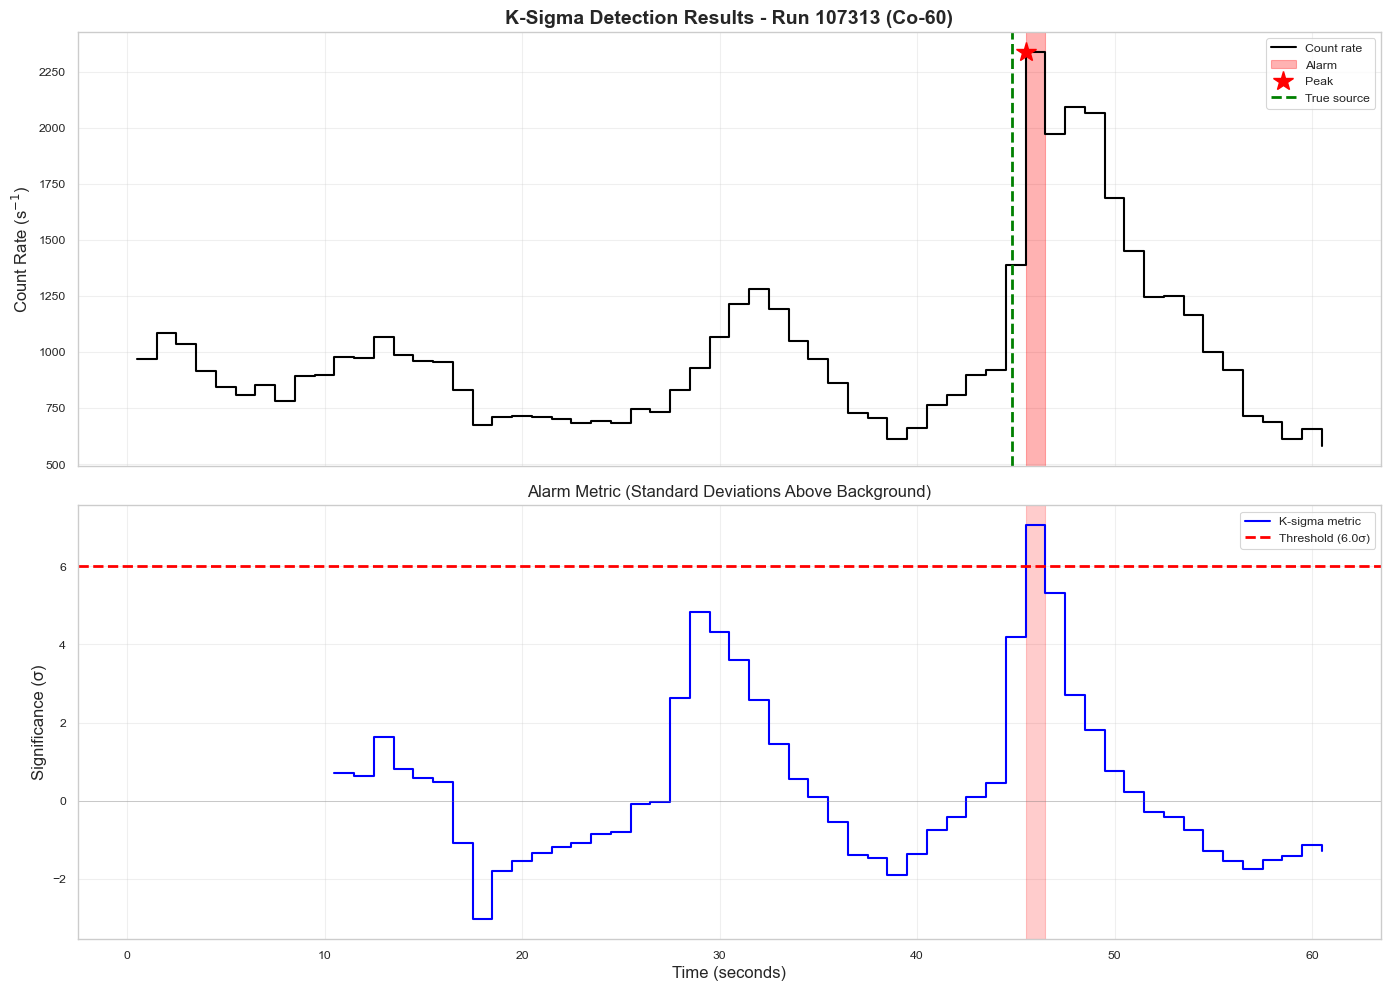


✅ Visualization complete!


In [34]:
# Plot count rate with alarm overlay
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Get times and count rates (ensure they are 1D arrays)
times = time_series.timestamps
count_rates = np.array([
    float(s.counts.sum()) / float(s.live_time if s.live_time is not None else s.real_time)
    for s in time_series.spectra
])

# Plot 1: Count rate
ax1.step(times, count_rates, where='post', color='black', linewidth=1.5, label='Count rate')
ax1.set_ylabel(r'Count Rate (s$^{-1}$)', fontsize=12)
ax1.set_title(f'K-Sigma Detection Results - Run {run_id} ({metadata["SourceName"]})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Overlay alarm regions
for i, alarm in enumerate(detector.alarms):
    ax1.axvspan(alarm.start_time, alarm.end_time, alpha=0.3, color='red', 
                label='Alarm' if i == 0 else '')
    # Mark peak - find closest time index
    peak_idx = np.argmin(np.abs(times - alarm.peak_time))
    ax1.plot(alarm.peak_time, count_rates[peak_idx],
            'r*', markersize=15, label='Peak' if i == 0 else '')

# Mark true source time
if metadata['SourceID'] != 0:
    ax1.axvline(metadata['SourceTime'], color='green', linestyle='--', 
                linewidth=2, label='True source')

ax1.legend(loc='best')

# Plot 2: K-sigma metric
ax2.step(times, metrics, where='post', color='blue', linewidth=1.5, label='K-sigma metric')
ax2.axhline(detector.k_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({detector.k_threshold}σ)')
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Significance (σ)', fontsize=12)
ax2.set_title('Alarm Metric (Standard Deviations Above Background)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Overlay alarm regions on metric plot too
for alarm in detector.alarms:
    ax2.axvspan(alarm.start_time, alarm.end_time, alpha=0.2, color='red')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

## ROI-Based Detection

Now let's demonstrate improved performance using Energy Regions of Interest (ROIs).

**Strategy**: Instead of using all 512 energy bins, we'll define ROIs that:
1. Capture Co-60's characteristic gamma rays (1173 keV and 1332 keV)
2. Include a baseline region for comparison
3. Reduce noise from irrelevant energy channels

This should improve signal-to-noise ratio and detection sensitivity.


In [35]:
# Import ROI utilities
from gammaflow.operations.roi import EnergyROI, rebin_time_series_rois, create_roi_collection

# Define ROIs for Co-60 detection
# Co-60 emits two gamma rays: 1173 keV and 1332 keV
# We'll create windows around these peaks plus a baseline region

roi_definitions = [
    (1100, 1250, "Co-60 Peak 1"),  # First gamma ray (1173 keV)
    (1250, 1400, "Co-60 Peak 2"),  # Second gamma ray (1332 keV)
]

# Create ROI collection
rois = create_roi_collection(roi_definitions, method="manual")

print("Defined ROIs:")
for roi in rois:
    print(f"  {roi}")

# Rebin time series using ROIs
print("\nRebinning time series using ROIs...")
roi_counts, roi_labels = rebin_time_series_rois(time_series, rois, return_labels=True)

print(f"\nROI-rebinned data shape: {roi_counts.shape}")
print(f"  {time_series.n_spectra} time points × {len(rois)} ROIs")
print(f"  Reduced from {energy_bins} bins to {len(rois)} bins")
print(f"  Compression: {energy_bins / len(rois):.1f}x")

# ROI counts shape: (n_spectra, n_rois)
# For K-Sigma detection, we want the TOTAL count rate from selected ROIs
# (not individual ROI rates, but their sum)

print(f"\nROI counts array shape: {roi_counts.shape}")
print(f"  {time_series.n_spectra} time points × {len(rois)} ROIs")

# Calculate total counts from selected ROIs at each time point
roi_total_counts = roi_counts.sum(axis=1)  # Sum across ROIs

print(f"\nTotal ROI counts per time: {roi_total_counts.shape}")
print(f"  Min: {roi_total_counts.min():.1f}, Max: {roi_total_counts.max():.1f}, Mean: {roi_total_counts.mean():.1f}")

# For visualization purposes, create a simple "ROI spectrum" with synthetic bins
# Each ROI becomes one "bin" in a synthetic energy space (just for K-Sigma input)
roi_edges = np.arange(len(rois) + 1, dtype=float)

# Extract timing info properly from the original time series
# Need to get the actual values from individual spectra if needed
print(f"\nOriginal time series timing info:")
print(f"  timestamps: {type(time_series.timestamps)}")
print(f"  real_times: {type(time_series.real_times)}")
print(f"  live_times: {type(time_series.live_times)}")

# Get live times as an array from individual spectra
live_times_array = np.array([
    s.live_time if s.live_time is not None else s.real_time 
    for s in time_series.spectra
])
real_times_array = np.array([s.real_time for s in time_series.spectra])

print(f"\nExtracted live times: min={live_times_array.min():.3f}, max={live_times_array.max():.3f}, mean={live_times_array.mean():.3f}")

roi_time_series = SpectralTimeSeries.from_array(
    roi_counts,
    energy_edges=roi_edges,
    timestamps=time_series.timestamps,
    real_times=real_times_array,
    live_times=live_times_array
)

print(f"\nCreated ROI-based time series: {roi_time_series}")
print(f"  Note: The K-Sigma detector will sum these {len(rois)} ROIs")
print(f"  Actual energy ranges maintained in 'rois' list:")
for i, roi in enumerate(rois):
    print(f"    Bin {i}: {roi.label} = {roi.e_min:.0f}-{roi.e_max:.0f} keV")
print("\n✅ ROI rebinning complete!")


Defined ROIs:
  EnergyROI('Co-60 Peak 1', e_min=1100.0, e_max=1250.0, method='manual')
  EnergyROI('Co-60 Peak 2', e_min=1250.0, e_max=1400.0, method='manual')

Rebinning time series using ROIs...

ROI-rebinned data shape: (61, 2)
  61 time points × 2 ROIs
  Reduced from 512 bins to 2 bins
  Compression: 256.0x

ROI counts array shape: (61, 2)
  61 time points × 2 ROIs

Total ROI counts per time: (61,)
  Min: 9.0, Max: 288.0, Mean: 32.8

Original time series timing info:
  timestamps: <class 'numpy.ndarray'>
  real_times: <class 'numpy.ndarray'>
  live_times: <class 'numpy.ndarray'>

Extracted live times: min=1.000, max=1.000, mean=1.000

Created ROI-based time series: SpectralTimeSeries(n_spectra=61, n_bins=2, calibrated, calibration_mode=shared)
  Note: The K-Sigma detector will sum these 2 ROIs
  Actual energy ranges maintained in 'rois' list:
    Bin 0: Co-60 Peak 1 = 1100-1250 keV
    Bin 1: Co-60 Peak 2 = 1250-1400 keV

✅ ROI rebinning complete!


ROI Time Series Diagnostics:
  n_spectra: 61
  n_bins: 2

Timestamps:
  Type: <class 'numpy.ndarray'>
  Shape: (61,)
  Min: 0.50, Max: 60.50
  First 5: [0.5 1.5 2.5 3.5 4.5]

Real times:
  Type: <class 'numpy.ndarray'>
  Shape: (61,)

Live times:
  Type: <class 'numpy.ndarray'>
  Shape: (61,)
  First 5: [1. 1. 1. 1. 1.]

Counts array:
  Shape: (61, 2)
  Min: 2.0, Max: 157.0
  Sum per spectrum (first 5): [np.float64(20.0), np.float64(27.0), np.float64(30.0), np.float64(26.0), np.float64(21.0)]

Manual count rate calculation:
  Spectrum 0: 20.0 counts / 1.000s = 20.00 cps
  Spectrum 1: 27.0 counts / 1.000s = 27.00 cps
  Spectrum 2: 30.0 counts / 1.000s = 30.00 cps



(<Figure size 1200x500 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Gross Count Rate (s$^{-1}$)'>)

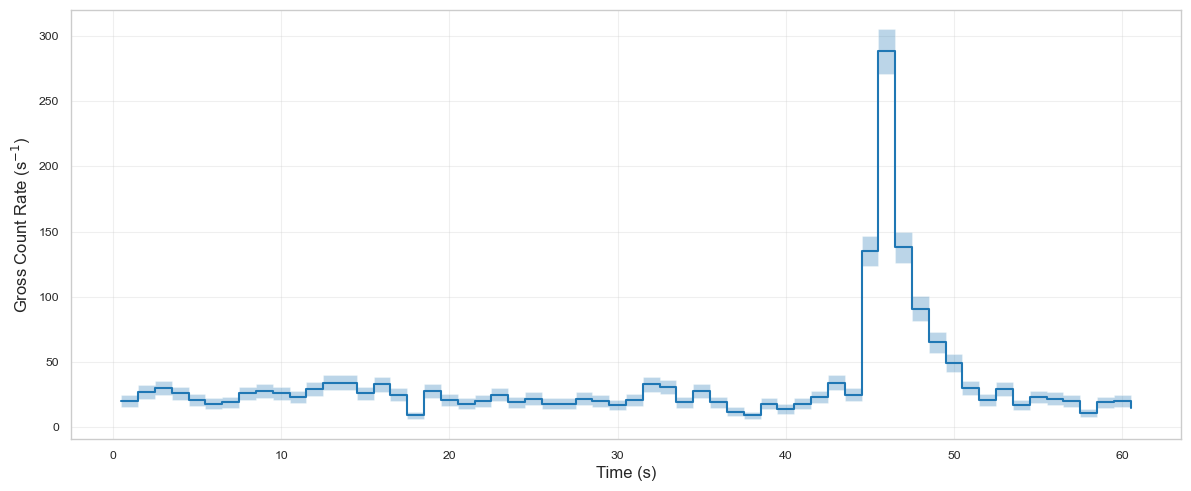

In [36]:
# Diagnostic: Check roi_time_series data before plotting
print("ROI Time Series Diagnostics:")
print(f"  n_spectra: {roi_time_series.n_spectra}")
print(f"  n_bins: {roi_time_series.n_bins}")
print(f"\nTimestamps:")
print(f"  Type: {type(roi_time_series.timestamps)}")
print(f"  Shape: {roi_time_series.timestamps.shape if roi_time_series.timestamps is not None else 'None'}")
if roi_time_series.timestamps is not None:
    print(f"  Min: {roi_time_series.timestamps.min():.2f}, Max: {roi_time_series.timestamps.max():.2f}")
    print(f"  First 5: {roi_time_series.timestamps[:5]}")

print(f"\nReal times:")
print(f"  Type: {type(roi_time_series.real_times)}")
if hasattr(roi_time_series.real_times, 'shape'):
    print(f"  Shape: {roi_time_series.real_times.shape}")
elif roi_time_series.real_times is not None:
    print(f"  Value: {roi_time_series.real_times}")

print(f"\nLive times:")
print(f"  Type: {type(roi_time_series.live_times)}")
if roi_time_series.live_times is not None and hasattr(roi_time_series.live_times, 'shape'):
    print(f"  Shape: {roi_time_series.live_times.shape}")
    print(f"  First 5: {roi_time_series.live_times[:5]}")

print(f"\nCounts array:")
print(f"  Shape: {roi_time_series.counts.shape}")
print(f"  Min: {roi_time_series.counts.min():.1f}, Max: {roi_time_series.counts.max():.1f}")
print(f"  Sum per spectrum (first 5): {[s.counts.sum() for s in roi_time_series.spectra[:5]]}")

# Try to manually calculate count rates
print(f"\nManual count rate calculation:")
for i in range(min(3, roi_time_series.n_spectra)):
    spec = roi_time_series.spectra[i]
    total_counts = spec.counts.sum()
    live_time = spec.live_time if spec.live_time is not None else spec.real_time
    rate = total_counts / live_time if live_time and live_time > 0 else 0
    print(f"  Spectrum {i}: {total_counts:.1f} counts / {live_time:.3f}s = {rate:.2f} cps")

print("\n" + "="*70)
plot_count_rate_time_series(roi_time_series)

## Run K-Sigma on ROI Data

Now we'll run the same K-Sigma detector on the ROI-based time series and compare results.


In [37]:
# Create detector with same parameters
detector_roi = KSigmaDetector(
    k_threshold=6.0,
    background_window=10.0,
    foreground_window=1.0,
    aggregation_gap=2.0,
    min_background_samples=10
)

print(f"Running K-Sigma Detection on ROI Data")
print(f"{'='*70}")
print(f"  Using {len(rois)} ROIs instead of {energy_bins} bins")
print()

# Process ROI time series
metrics_roi = detector_roi.process_time_series(roi_time_series)

# Get summary
summary_roi = detector_roi.get_alarm_summary()

print(f"\n{'='*70}")
print(f"ROI-Based Detection Results")
print(f"{'='*70}")
print(f"Number of alarms: {summary_roi['n_alarms']}")
print(f"Total alarm time: {summary_roi['total_alarm_time']:.2f} seconds")
if summary_roi['n_alarms'] > 0:
    print(f"Mean alarm duration: {summary_roi['mean_duration']:.2f} seconds")
    print(f"Peak significance: {summary_roi['max_peak_metric']:.2f} sigma")

if detector_roi.alarms:
    print(f"\nAlarm Events:")
    true_source_time = metadata['SourceTime']
    for i, alarm in enumerate(detector_roi.alarms, 1):
        print(f"  {i}. {alarm}")
        # Compare to ground truth
        if alarm.start_time <= true_source_time <= alarm.end_time:
            print(f"      ✅ Captured true source (t={true_source_time:.1f}s)")
        else:
            time_diff = min(abs(alarm.start_time - true_source_time),
                          abs(alarm.end_time - true_source_time))
            print(f"      ⚠️  Offset from true source: {time_diff:.1f}s")

# Compare with full-spectrum results
print(f"\n{'='*70}")
print(f"Comparison: Full Spectrum vs ROI-Based")
print(f"{'='*70}")
print(f"{'Method':<20} {'Alarms':<10} {'Peak σ':<10} {'Duration':<15}")
print(f"{'-'*70}")
print(f"{'Full Spectrum':<20} {summary['n_alarms']:<10} {summary['max_peak_metric']:<10.2f} {summary['total_alarm_time']:<15.2f}")
print(f"{'ROI-Based':<20} {summary_roi['n_alarms']:<10} {summary_roi['max_peak_metric']:<10.2f} {summary_roi['total_alarm_time']:<15.2f}")

# Calculate improvement
if summary['max_peak_metric'] > 0:
    improvement = (summary_roi['max_peak_metric'] - summary['max_peak_metric']) / summary['max_peak_metric'] * 100
    print(f"\nPeak significance improvement: {improvement:+.1f}%")


Running K-Sigma Detection on ROI Data
  Using 2 ROIs instead of 512 bins


ROI-Based Detection Results
Number of alarms: 1
Total alarm time: 5.00 seconds
Mean alarm duration: 5.00 seconds
Peak significance: 37.00 sigma

Alarm Events:
  1. AlarmEvent(start=44.50s, end=49.50s, peak=37.00σ at 45.50s, duration=5.00s)
      ✅ Captured true source (t=44.8s)

Comparison: Full Spectrum vs ROI-Based
Method               Alarms     Peak σ     Duration       
----------------------------------------------------------------------
Full Spectrum        1          7.05       1.00           
ROI-Based            1          37.00      5.00           

Peak significance improvement: +424.5%


## Visualize ROI-Based Results

Compare the full-spectrum and ROI-based detection side-by-side.


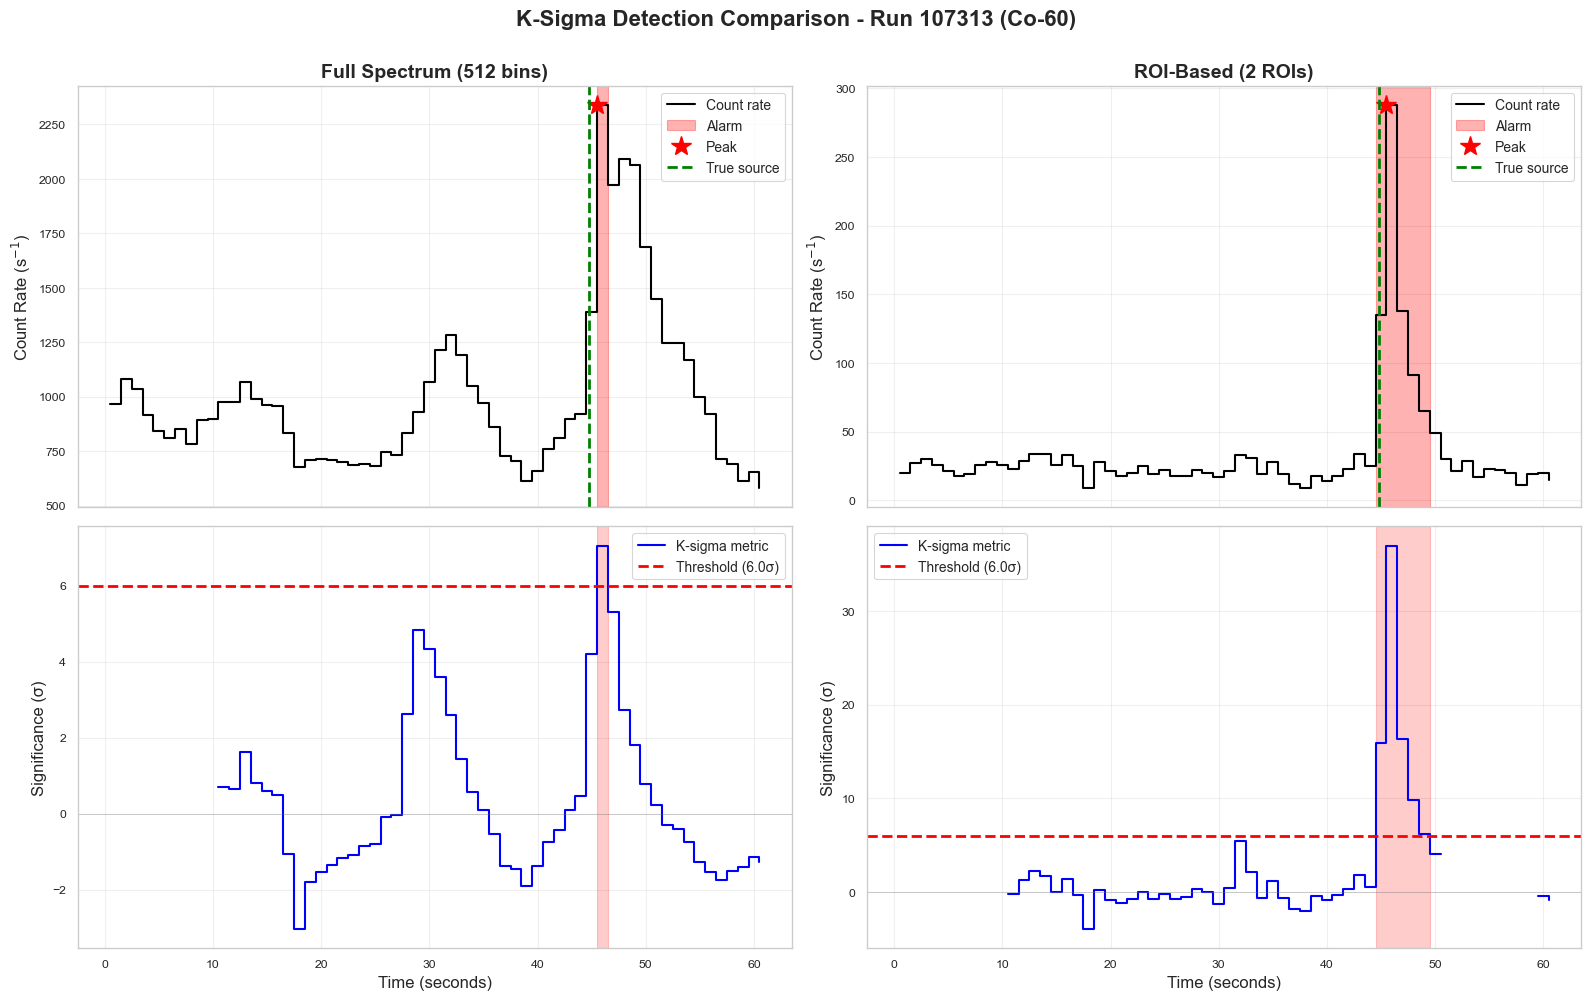


✅ Comparison visualization complete!


In [38]:
# Create side-by-side comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# --- LEFT COLUMN: Full Spectrum ---
ax1, ax3 = axes[:, 0]

# Plot 1: Full spectrum count rate
ax1.step(times, count_rates, where='post', color='black', linewidth=1.5, label='Count rate')
ax1.set_ylabel(r'Count Rate (s$^{-1}$)', fontsize=12)
ax1.set_title(f'Full Spectrum ({energy_bins} bins)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Overlay alarm regions
for i, alarm in enumerate(detector.alarms):
    ax1.axvspan(alarm.start_time, alarm.end_time, alpha=0.3, color='red', 
                label='Alarm' if i == 0 else '')
    peak_idx = np.argmin(np.abs(times - alarm.peak_time))
    ax1.plot(alarm.peak_time, count_rates[peak_idx],
            'r*', markersize=15, label='Peak' if i == 0 else '')

# Mark true source time
if metadata['SourceID'] != 0:
    ax1.axvline(metadata['SourceTime'], color='green', linestyle='--', 
                linewidth=2, label='True source')

ax1.legend(loc='best', fontsize=10)

# Plot 3: Full spectrum K-sigma metric
ax3.step(times, metrics, where='post', color='blue', linewidth=1.5, label='K-sigma metric')
ax3.axhline(detector.k_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({detector.k_threshold}σ)')
ax3.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Significance (σ)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', fontsize=10)

# Overlay alarm regions
for alarm in detector.alarms:
    ax3.axvspan(alarm.start_time, alarm.end_time, alpha=0.2, color='red')

# --- RIGHT COLUMN: ROI-Based ---
ax2, ax4 = axes[:, 1]

# Calculate ROI-based count rates
roi_count_rates = np.array([
    float(s.counts.sum()) / float(s.live_time if s.live_time is not None else s.real_time)
    for s in roi_time_series.spectra
])

# Plot 2: ROI-based count rate
ax2.step(times, roi_count_rates, where='post', color='black', linewidth=1.5, label='Count rate')
ax2.set_ylabel(r'Count Rate (s$^{-1}$)', fontsize=12)
ax2.set_title(f'ROI-Based ({len(rois)} ROIs)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Overlay alarm regions
for i, alarm in enumerate(detector_roi.alarms):
    ax2.axvspan(alarm.start_time, alarm.end_time, alpha=0.3, color='red', 
                label='Alarm' if i == 0 else '')
    peak_idx = np.argmin(np.abs(times - alarm.peak_time))
    ax2.plot(alarm.peak_time, roi_count_rates[peak_idx],
            'r*', markersize=15, label='Peak' if i == 0 else '')

# Mark true source time
if metadata['SourceID'] != 0:
    ax2.axvline(metadata['SourceTime'], color='green', linestyle='--', 
                linewidth=2, label='True source')

ax2.legend(loc='best', fontsize=10)

# Plot 4: ROI-based K-sigma metric
ax4.step(times, metrics_roi, where='post', color='blue', linewidth=1.5, label='K-sigma metric')
ax4.axhline(detector_roi.k_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({detector_roi.k_threshold}σ)')
ax4.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax4.set_xlabel('Time (seconds)', fontsize=12)
ax4.set_ylabel('Significance (σ)', fontsize=12)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=10)

# Overlay alarm regions
for alarm in detector_roi.alarms:
    ax4.axvspan(alarm.start_time, alarm.end_time, alpha=0.2, color='red')

plt.suptitle(f'K-Sigma Detection Comparison - Run {run_id} ({metadata["SourceName"]})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print("\n✅ Comparison visualization complete!")
